# Регуляризация нейронных сетей

Имя, Фамилия: Гурулева Наталья

---

В этом задании вам необходимо будет реализовать 2 подхода к регуляризации нейронных сетей через ограничения структуры:

*   Dropout
*   Batch normalization

После нужно будет понаблюдать, как они влияют на качество построенной нейронной сети на датасете **CIFAR-10** (Canadian Institute For Advanced Research).

CIFAR-10 состоит из 60k цветных изображений размером 32x32, разделенных на 10 классов, по 6k изображений на каждый класс (train - 50k, test - 10k).

*Подробнее про данные можно посмотреть [тут](https://www.cs.toronto.edu/~kriz/cifar.html)*





In [1]:
import torchvision.transforms as transforms
from torchvision.datasets import CIFAR10
from torch.utils.data import DataLoader
from torchvision.utils import make_grid

import numpy as np
import matplotlib.pyplot as plt

from tqdm.auto import trange

BATCH_SIZE = 64

In [2]:
from tqdm import tqdm

Загрузим данные и посмотрим на них:

In [3]:
transform = transforms.Compose(
    [transforms.Grayscale(num_output_channels=1),
     transforms.ToTensor()])

trainset = CIFAR10(root='./data', train=True, download=True, transform=transform)
trainloader = DataLoader(trainset, batch_size=BATCH_SIZE, shuffle=True, num_workers=2)

testset = CIFAR10(root='./data', train=False, download=True, transform=transform)
testloader = DataLoader(testset, batch_size=BATCH_SIZE, shuffle=False, num_workers=2)

100%|██████████| 170M/170M [00:03<00:00, 53.5MB/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


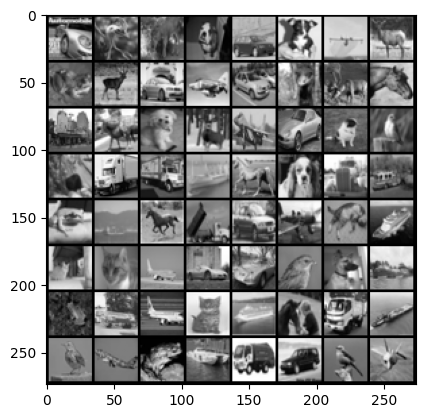

In [4]:
def imshow(img):
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

dataiter = iter(trainloader)
images, labels = next(dataiter)

imshow(make_grid(images))

Переиспользуем классы из предыдущего занятия *с минорными изменениями*

In [5]:
class Module:
    """
    Базовый класс для построения модулей нейронной сети.

    Этот класс предоставляет интерфейс для создания и использования модулей,
    составляющих нейронную сеть.  Он определяет основные методы, которые должны
    быть реализованы в каждом конкретном модуле.

    Attributes:
        mode (str): Режим работы модуля ('train' или 'test').
            Устанавливается с помощью метода set_mode. По умолчанию 'train'.

    Notes:
        Этот класс является абстрактным и не должен использоваться напрямую.
        Он предназначен для создания конкретных модулей нейронной сети, которые
        наследуются от него и реализуют необходимые методы.
    """

    def __init__(self):
        self.mode = 'train'

    def set_mode(self, mode: str) -> None:
        """
        Устанавливает режим работы модуля.

        Args:
            mode (str): Режим работы модуля ('train' или 'test').
        """

        assert mode in ['train', 'test']
        self.mode = mode

    def forward(self, x: np.ndarray) -> np.ndarray:
        """
        Метод для прямого прохода

        Args:
            x (np.ndarray): Входные данные. Размерность может быть (batch_size,
              in_features) или (in_features,) для вектора.

        Returns:
            np.ndarray: Выходные данные после линейного преобразования
            (размерность: (batch_size, out_features) или (out_features,) для вектора).
        """
        pass

    def backward(self, gradient: np.ndarray) -> np.ndarray:
        """
        Метод для обратного прохода

        Args:
            gradient (np.ndarray): Градиент ошибки, полученный от следующего слоя.
            Размерность может быть (batch_size, out_features) или (out_features,)
            для вектора.

        Returns:
            np.ndarray: Градиент ошибки для предыдущего слоя
            (размерность: (batch_size, in_features) или (in_features,) для вектора).
        """
        pass

    def update(self, learning_rate: float) -> None:
        """
        Метод для обновления параметров модуля

        Args:
            learning_rate (float): Скорость обучения.
        """
        pass

In [6]:
class Linear(Module):
    """
    Реализует полносвязный линейный слой.

    Этот слой выполняет линейное преобразование входных данных: y = xW + b,
    где W - матрица весов, b - вектор смещения, а x - входные данные.

    Args:
        in_features (int): Количество входных признаков.
        out_features (int): Количество выходных признаков.
    """

    def __init__(self, in_features: int, out_features: int):
        super().__init__()
        self.in_features = in_features
        self.out_features = out_features
        self.bias = np.random.randn(out_features) * np.sqrt(2 / in_features)
        self.weight = np.random.randn(out_features, in_features) * np.sqrt(2 / in_features)

    def forward(self, x: np.ndarray) -> np.ndarray:
        self.x = x
        self.y = x @ self.weight.T + self.bias
        return self.y


    def backward(self, gradient: np.ndarray) -> np.ndarray:
        self.gradient_x = gradient @ self.weight
        if self.x.ndim == 1:
            self.gradient_W = gradient[np.newaxis, :].T @ self.x[np.newaxis, :]
        else:
            self.gradient_W = gradient.T @ self.x
        self.gradient_b = np.sum(gradient, axis=0)
        return self.gradient_x


    def update(self, learning_rate: float) -> None:
        self.weight -= learning_rate * self.gradient_W
        self.bias -= learning_rate * self.gradient_b

In [7]:
class ReLU(Module):
    """
    Реализация функции активации ReLU.

    ReLU применяет поэлементную операцию к входным данным,
    заменяя все отрицательные значения на ноль.
    """

    def __init__(self):
        super().__init__()

    def forward(self, x: np.ndarray) -> np.ndarray:
        self.x = x
        self.y = np.maximum(x, 0)
        return self.y

    def backward(self, gradient: np.ndarray) -> np.ndarray:
        self.gradient_x = (self.x > 0) * gradient
        return self.gradient_x

# Задание 1: обучение полносвязной сети (1 балл)

Обучите полносвязную нейронную сеть на заданных данных и протестируйте ее на тестовом датасете

In [12]:
class Net:
    """
    Реализация нейронной сети с использованием модульной структуры.

    Attributes:
        modules (list[Module]): Список модулей, составляющих сеть.
        learning_rate (float):  Скорость обучения, используемая при обновлении параметров модулей.
        max_iter (int): Максимальное количество эпох обучения.
    """

    def __init__(self,
                 modules: list[Module],
                 learning_rate: float = 0.001,
                 max_iter: int = 10):

        self.modules = modules
        self.learning_rate = learning_rate
        self.max_iter = max_iter

    def __set_mode(self, mode: str):
        """
        Устанавливает режим работы для каждого модуля в сети.

        Args:
            mode (str): Режим работы для каждого модуля ('train' или 'test').
        """

        for i in range(len(self.modules)):
            self.modules[i].set_mode(mode)

    def train(self, trainloader: DataLoader) -> None:
        """
        Обучает модель на заданных данных.

        Args:
            trainloader (DataLoader): Загрузчик данных,
            предоставляющий батчи обучающих данных.
        """

        self.__set_mode('train')
        for epoch in tqdm(range(self.max_iter)):
            loss = []
            for data in trainloader:
                x, y = data
                x = x.numpy()
                y = y.numpy()
                x = x.reshape(x.shape[0], -1)
                n_classes = 10
                y_train = np.zeros((y.shape[0], n_classes))
                y_train[np.arange(y.shape[0]), y] = 1
                outp = x
                for module in self.modules:
                    outp = module.forward(outp)
                y_pred = np.exp(outp) / np.sum(np.exp(outp), axis=1)[:, np.newaxis]
                loss.append(-np.mean(np.sum(y_train * np.log(y_pred), axis=1)))
                grad = y_pred - y_train
                for module in reversed(self.modules):
                    grad = module.backward(grad)
                    module.update(self.learning_rate)
            print(f'epoch: {epoch}, loss: ', np.array(loss).mean())


    def predict(self, X: np.ndarray) -> np.ndarray:
        """
        Делает предсказание на заданных входных данных.

        Args:
            X (np.ndarray): Матрица входных данных.

        Returns:
            np.ndarray: Матрица предсказанных значений.
        """

        self.__set_mode('test')
        outp = X
        for module in self.modules:
            outp = module.forward(outp)
        y_pred = np.exp(outp) / np.sum(np.exp(outp), axis=1)[:, np.newaxis]
        return y_pred

Функция для тестирования

In [9]:
def calculate_accuracy(model: Net, dataloader: DataLoader) -> float:
  """
  Вычисляет точность модели на заданном даталоадере.

  Args:
    model (Net): Модель для тестирования.
    dataloader (DataLoader): Загрузчик данных, предоставляющий батчи тестовых данных.

  Returns:
    float: Accuarcy.
  """
  correct = 0
  total = 0

  for data in dataloader:
    inputs, labels = data
    inputs = inputs.numpy()
    inputs = inputs.reshape(inputs.shape[0], -1)

    outputs = model.predict(inputs)
    predicted = np.argmax(outputs, axis=1)
    total += labels.size(0)
    correct += (predicted == labels).sum().item()

  return correct / total

In [13]:
model = Net(modules=[Linear(1024, 333), ReLU(), Linear(333, 111), ReLU(), Linear(111, 10)], max_iter=10)
model.train(trainloader)

 10%|█         | 1/10 [00:20<03:03, 20.40s/it]

epoch: 0, loss:  2.0357384345680476


 20%|██        | 2/10 [00:40<02:40, 20.10s/it]

epoch: 1, loss:  1.8830532871399646


 30%|███       | 3/10 [00:58<02:15, 19.33s/it]

epoch: 2, loss:  1.8139130171580151


 40%|████      | 4/10 [01:19<01:59, 19.92s/it]

epoch: 3, loss:  1.765867331204528


 50%|█████     | 5/10 [01:37<01:36, 19.25s/it]

epoch: 4, loss:  1.725697437737032


 60%|██████    | 6/10 [01:58<01:19, 19.95s/it]

epoch: 5, loss:  1.693840006572472


 70%|███████   | 7/10 [02:19<01:00, 20.15s/it]

epoch: 6, loss:  1.6629418842934143


 80%|████████  | 8/10 [02:39<00:40, 20.02s/it]

epoch: 7, loss:  1.6392415438342154


 90%|█████████ | 9/10 [02:59<00:19, 19.98s/it]

epoch: 8, loss:  1.6146314367373031


100%|██████████| 10/10 [03:19<00:00, 19.98s/it]

epoch: 9, loss:  1.5934681499148782


In [14]:
calculate_accuracy(model=model, dataloader=testloader)

0.4036

# Задание 2: Dropout (2 балла)

Реализуйте слой Dropout.

In [18]:
class Dropout(Module):
    """
    Реализует слой Dropout для регуляризации нейронной сети.

    Dropout случайным образом обнуляет нейроны входного слоя во время обучения,
    чтобы предотвратить переобучение.  Во время тестирования, слой Dropout
    не влияет на входные данные, просто пропуская их без изменений.

    Args:
        p (float): Вероятность того, что нейрон будет обнулен.
                   Значение должно быть между 0 и 1. По умолчанию 0.1.
    """

    def __init__(self, p: float = 0.1):
        super().__init__()
        self.p = p
        self.mask = None
        self.x = None

    def forward(self, x: np.ndarray) -> np.ndarray:
      if self.mode == 'train':
          self.mask = np.random.binomial(size=len(x), n=1, p=1 - self.p)[:, np.newaxis]
          self.x = x * self.mask / (1 - self.p)
      elif self.mode == 'test':
          self.x = x
      else:
          raise ValueError(f'Invalid mode: {self.mode}')
      return self.x

    def backward(self, gradient: np.ndarray) -> np.ndarray:
        return gradient * self.mask / (1 - self.p)

# Задание 3: Batch Normalization (4 балла)

Реализуйте слой Batch Normalization для одномерного случая.

Формулы для обратного прохода можно найти в оригинальной [статье](https://arxiv.org/abs/1502.03167).

*Подсказка:* вот [разбор](https://kratzert.github.io/2016/02/12/understanding-the-gradient-flow-through-the-batch-normalization-layer.html) того, как работает метод обратного распространения ошибки в слое batch normalization.


In [19]:
class BatchNorm1d(Module):
    """
    Реализует слой Batch Normalization для 1D данных.

    Batch Normalization нормализует активации каждого батча данных,
    чтобы ускорить обучение и улучшить обобщающую способность модели.

    Во время обучения вычисляются среднее и дисперсия для каждого мини-пакета,
    которые используются для нормализации.  Кроме того, вычисляются скользящие
    средние этих статистик для использования во время инференса.

    Args:
        in_features (int): Количество входных признаков.
        eps (float): Небольшое значение, добавленное к дисперсии для
                     предотвращения деления на ноль. По умолчанию 1e-5.
        lamda (float): Фактор затухания для вычисления скользящих средних
                      среднего и дисперсии. По умолчанию 0.9.

    Attributes:
        eps (float): Небольшое значение для предотвращения деления на ноль.
        lamda (float): Фактор затухания для скользящих средних.

        gamma (np.ndarray): Масштабируемый параметр (размер `in_features`).
        beta (np.ndarray): Параметр сдвига (размер `in_features`).

        running_mean (np.ndarray): Скользящее среднее среднего (размер `in_features`).
        running_var (np.ndarray): Скользящее среднее дисперсии (размер `in_features`).
    """

    def __init__(self, in_features: int, eps: float = 1e-5, lamda: float = 0.9):
        super().__init__()
        self.eps = eps
        self.lamda = lamda

        self.gamma = np.random.randn(in_features)
        self.beta = np.zeros(in_features)

        self.running_mean = np.zeros(in_features)
        self.running_var = np.zeros(in_features)

        self.mean = None
        self.var = None
        self.std = None


    def forward(self, x: np.ndarray) -> np.ndarray:
        self.x = x
        if self.mode == 'train':
            self.mean = x.mean(axis=0)
            self.running_mean = self.lamda * self.running_mean + (1 - self.lamda) * self.mean
            self.var = x.var(axis=0)
            self.running_var = self.lamda * self.running_var + (1 - self.lamda) * self.var
            self.x_hat = (x - self.mean) / np.sqrt(self.var + self.eps)
        elif self.mode == 'test':
            self.x_hat = (self.x - self.running_mean) / np.sqrt(self.running_var + self.eps)
        else:
            raise ValueError(f'Invalid mode: {self.mode}')
        return self.gamma * self.x_hat + self.beta


    def backward(self, gradient: np.ndarray) -> np.ndarray:

        grad_xhat = gradient * self.gamma
        grad_var = - 0.5 * np.sum(grad_xhat * (self.x - self.mean) / ((self.var + self.eps) ** 1.5), axis=0)
        grad_mean = -np.sum(grad_xhat / np.sqrt(self.var + self.eps), axis=0) + grad_var * np.sum(-2 * (self.x - self.mean), axis=0) / len(self.x)
        grad_x = grad_xhat / np.sqrt(self.var + self.eps) + grad_mean / len(self.x) + grad_var * 2 * (self.x - self.mean) / len(self.x)
        self.grad_gamma = np.sum(gradient * self.x_hat, axis=0)
        self.grad_beta = np.sum(gradient, axis=0)
        return grad_x


    def update(self, learning_rate: float) -> None:

      self.gamma -= learning_rate * self.grad_gamma
      self.beta -= learning_rate * self.grad_beta

# Задание 4: Обучение полносвязной сети с регуляризацией (3 балла)

Обучите полносвязную нейронную сеть на заданных данных с использованием слоев Dropout и Batch normalization, реализованных в предыдущих заданиях. Протестируйте полученную модель на тестовом датасете.

Добавим один слой нормализации после первого линейного слоя к модели выше:

In [20]:
model = Net(modules=[Linear(1024, 333), BatchNorm1d(333), ReLU(), Linear(333, 111), ReLU(), Linear(111, 10)], max_iter=10)
model.train(trainloader)

 10%|█         | 1/10 [00:21<03:16, 21.87s/it]

epoch: 0, loss:  1.8883429486052026


 20%|██        | 2/10 [00:42<02:48, 21.00s/it]

epoch: 1, loss:  1.7117952477049785


 30%|███       | 3/10 [01:02<02:24, 20.66s/it]

epoch: 2, loss:  1.6216374280841428


 40%|████      | 4/10 [01:24<02:07, 21.30s/it]

epoch: 3, loss:  1.5618425566046223


 50%|█████     | 5/10 [01:46<01:46, 21.36s/it]

epoch: 4, loss:  1.5090397595913405


 60%|██████    | 6/10 [02:07<01:25, 21.44s/it]

epoch: 5, loss:  1.46142863600727


 70%|███████   | 7/10 [02:29<01:04, 21.49s/it]

epoch: 6, loss:  1.4221580397319116


 80%|████████  | 8/10 [02:50<00:42, 21.47s/it]

epoch: 7, loss:  1.3800595605894068


 90%|█████████ | 9/10 [03:12<00:21, 21.55s/it]

epoch: 8, loss:  1.3455454583157738


100%|██████████| 10/10 [03:34<00:00, 21.40s/it]

epoch: 9, loss:  1.3114742371056214


Точность повысилась на 0.03:

In [21]:
calculate_accuracy(model=model, dataloader=testloader)

0.4302

Теперь добавим Dropout слой:

In [27]:
model = Net(modules=[Linear(1024, 333), BatchNorm1d(333), ReLU(), Linear(333, 111), ReLU(), Dropout(), Linear(111, 10)], max_iter=10)
model.train(trainloader)

 10%|█         | 1/10 [00:20<03:07, 20.84s/it]

epoch: 0, loss:  1.9542572782718242


 20%|██        | 2/10 [00:43<02:54, 21.77s/it]

epoch: 1, loss:  1.7953259892941231


 30%|███       | 3/10 [01:06<02:36, 22.31s/it]

epoch: 2, loss:  1.7136764792512886


 40%|████      | 4/10 [01:26<02:09, 21.60s/it]

epoch: 3, loss:  1.6573132543966207


 50%|█████     | 5/10 [01:49<01:50, 22.02s/it]

epoch: 4, loss:  1.6118556786917275


 60%|██████    | 6/10 [02:11<01:27, 21.86s/it]

epoch: 5, loss:  1.566844843812969


 70%|███████   | 7/10 [02:31<01:04, 21.49s/it]

epoch: 6, loss:  1.5313611649389203


 80%|████████  | 8/10 [02:54<00:43, 21.75s/it]

epoch: 7, loss:  1.498264313204513


 90%|█████████ | 9/10 [03:14<00:21, 21.34s/it]

epoch: 8, loss:  1.469143243906871


100%|██████████| 10/10 [03:36<00:00, 21.64s/it]

epoch: 9, loss:  1.4319365140913147


Теперь accuracy еще немного выше:

In [28]:
calculate_accuracy(model=model, dataloader=testloader)

0.4418

С добавлением слоев стало хуже, возможно слишком сложная модель или излишняя регуляризация:

In [40]:
model = Net(modules=[
    Linear(1024, 512), BatchNorm1d(512), ReLU(),
    Linear(512, 256), BatchNorm1d(256), ReLU(), Dropout(0.1),
    Linear(256, 128), ReLU(),
    Linear(128, 64), BatchNorm1d(64), ReLU(), Dropout(0.1),
    Linear(64, 32), ReLU(),
    Linear(32, 10)
], max_iter=10)
model.train(trainloader)

 10%|█         | 1/10 [00:30<04:33, 30.34s/it]

epoch: 0, loss:  2.0127462983515394


 20%|██        | 2/10 [00:59<03:54, 29.37s/it]

epoch: 1, loss:  1.8533099161568225


 30%|███       | 3/10 [01:28<03:25, 29.41s/it]

epoch: 2, loss:  1.786754405668001


 40%|████      | 4/10 [01:57<02:55, 29.24s/it]

epoch: 3, loss:  1.7308409023429607


 50%|█████     | 5/10 [02:24<02:22, 28.55s/it]

epoch: 4, loss:  1.6886812428547198


 60%|██████    | 6/10 [02:55<01:57, 29.29s/it]

epoch: 5, loss:  1.6540704580674723


 70%|███████   | 7/10 [03:25<01:28, 29.36s/it]

epoch: 6, loss:  1.6186318995786477


 80%|████████  | 8/10 [03:54<00:58, 29.38s/it]

epoch: 7, loss:  1.5889464635223025


 90%|█████████ | 9/10 [04:22<00:29, 29.10s/it]

epoch: 8, loss:  1.5573436310016364


100%|██████████| 10/10 [04:53<00:00, 29.38s/it]

epoch: 9, loss:  1.5320744231306989


In [41]:
calculate_accuracy(model=model, dataloader=testloader)

0.3892

In [ ]:
# YOUR CODE

# Домашнее задание № 3

Выполните задания в этом ноутбуке, а также продемонстируйте влияние регуляризации на построенную модель. Напишите полученные выводы.

ВАЖНО: PyTorch можно использовать только для работы с данными.

+ Мягкий дедлайн: `12.02.25 23:59`
+ Жесткий дедлайн: `19.02.25 23:59` (половина баллов)


После жесткого дедлайна задание не принимается.